## Visualize flow data for clonal testing of eUniRep, Local Unirep, ASR, and Consensus sequence designs

Figure 2c

In [1]:
import os
import sys
import pickle
import glob
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy

sys.path.append('../common')
import data_io_utils
import paths
import constants
import utils
import plot_style_utils

sys.path.append('../A008_analyze_chip_1/')
import A008_common

import A009_common

%reload_ext autoreload
%autoreload 2

In [2]:
flow_df = pd.read_csv('A009e_post_chip_1_gfp_colony_pick_flow.csv')

print(flow_df.shape)
display(flow_df.head())

(80, 15)


,B525_rep1,V525_rep1,frac_retained_post_gate_rep1,total_events_rep1,well,B525_rep2,V525_rep2,frac_retained_post_gate_rep2,total_events_rep2,B525_mean,B525_std,V525_mean,V525_std,525_mean,525_std
0,0.991759,2.137487,0.681899,103882.0,A01,1.112362,2.137487,0.525539,122676.0,1.052060,0.060302,2.137487,0.000000,1.594774,0.060302
1,2.197789,1.655075,0.760318,104697.0,A02,2.227940,1.655075,0.727116,108405.0,2.212864,0.015075,1.655075,0.000000,1.933970,0.015075
2,1.896281,1.685226,0.737155,110392.0,A03,1.986734,1.745528,0.693249,112554.0,1.941508,0.045226,1.715377,0.030151,1.828442,0.054355
3,2.288241,1.805829,0.748580,105787.0,A04,2.227940,1.835980,0.685251,112944.0,2.258090,0.030151,1.820905,0.015075,2.039497,0.033710
4,2.288241,1.383719,0.771342,103915.0,A05,2.288241,1.353568,0.633971,120657.0,2.288241,0.000000,1.368643,0.015075,1.828442,0.015075


Link flow data with twist plate map and seq IDs

In [3]:
md_df = pd.read_csv('A009d_metadata_platemap_merged.csv', index_col=0)
md_df.rename(columns={'Well Location': 'well'}, inplace=True)

print(md_df.shape)

(77, 17)


In [4]:
FLOW_COLS_TO_KEEP = ['id', 'well', '525_mean', '525_std', 'seq']

flow_df = flow_df.merge(md_df, on='well', how='left')
flow_df = flow_df[FLOW_COLS_TO_KEEP]
flow_df.rename(columns={'seq':'man_flow_seq'}, inplace=True)

print(flow_df.shape)
display(flow_df.head())
display(flow_df.tail())

(80, 5)


,id,well,525_mean,525_std,man_flow_seq
0,GFP_SimAnneal-ET_Random_Init_1-0024-02-1d0c486...,A01,1.594774,0.060302,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGCLTLKF...
1,GFP_SimAnneal-ET_Global_Init_1-0024-01-3a0e3d4...,A02,1.933970,0.015075,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATIGKLTLKF...
2,GFP_SimAnneal-ET_Global_Init_1-0024-01-3a0e3d4...,A03,1.828442,0.054355,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATHGKLTIKF...
3,GFP_SimAnneal-ET_Global_Init_1-0024-03-3764e94...,A04,2.039497,0.033710,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
4,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,A05,1.828442,0.015075,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLSLKF...


,id,well,525_mean,525_std,man_flow_seq
75,GFP_SimAnneal-ET_Global_Init_2-0096-02-1f121a7...,H06,1.692764,0.045226,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLNLKF...
76,GFP_SimAnneal-ET_Global_Init_1-0096-02-341cf5c...,H07,2.114874,0.075377,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATFGKLTLKF...
77,N1_4_-6.833884__N11_1_-0.180372,H08,1.504322,0.099956,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
78,top_consensus_seq,H09,1.542010,0.015075,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
79,NaN,H10,1.760603,0.099956,NaN


Load up flow seq data

In [5]:
inf_brightness_data_file = os.path.join(data_io_utils.S3_DATA_ROOT, 'chip_1', 'A052b_Chip_1_inferred_brightness_v2.csv')

data_io_utils.sync_s3_path_to_local(inf_brightness_data_file, is_single_file=True)

flowseq_df = pd.read_csv(inf_brightness_data_file)

q = flowseq_df['id'].apply(lambda s: pd.Series(A008_common.split_seq_id_into_features(s)))
flowseq_df = flowseq_df.merge(q, left_index=True, right_index=True)

display(flowseq_df.head())
print(flowseq_df.columns)

,id,qfunc,qfunc_rep1,qfunc_rep2,extracted_lib_nt_seq,seq_idx,trajectory_idx,predicted_fitness,ensemble_predicted_fitness,seq,...,DE_Chip_1_GFP_NGS_15,DE_Chip_1_GFP_NGS_16,DE_Chip_1_GFP_NGS_17,DE_Chip_1_GFP_NGS_18,model,ntrain,rep,rep_hash,seq_traj_idx,special_case
0,GFP_SimAnneal-ET_Global_Init_2-0024-04-36079a2...,2.205245,2.335832,2.205245,AAAACAGAGGGTCCTAGAGACGCAACTTATGGTAAAATGACGCCGA...,2719.0,1741.0,9.660326e+07,[-4.4425168e+00 -4.4221644e+00 -5.1892853e+00 ...,MSKGEELFTGVVPILVELDGDVNGHKFSVKTEGPRDATYGKMTPKF...,...,0.0,0.0,0.0,0.0,ET_Global_Init_2,24.0,4.0,36079a2c,seq_idx_2719_1741,
1,GFP_SimAnneal-OneHot-0024-04-4279eeb-seq_idx_2...,1.945739,2.011986,1.945739,AAAACAGAGGGTGAAGGTGACGCAACTTATGGTAAACTGAGCCTGA...,2601.0,1191.0,7.883185e-01,[0.73590547 0.76271843 0.77913585 0.75764891 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKTEGEGDATYGKLSLKF...,...,0.0,0.0,0.0,0.0,OneHot,24.0,4.0,4279eeb,seq_idx_2601_1191,
2,GFP_SimAnneal-ET_Random_Init_1-0024-04-1989c09...,2.079981,2.279340,2.079981,AAAATGGAGGGTGAAGGTAATCCTACTGGTGGTAAACTGATTCAGA...,454.0,2029.0,7.540600e-01,[0.7710203 0.7359552 0.6161216 0.77072877 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKMEGEGNPTGGKLIQKF...,...,0.0,0.0,0.0,0.0,ET_Random_Init_1,24.0,4.0,1989c098,seq_idx_454_2029,
3,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.180828,2.236717,2.180828,AAAGGCATAGGTGAAGGTGACGCAACTATGGGTAAACTGACGATTC...,1809.0,1276.0,7.377951e-01,[1.0700963 0.7323966 0.79640985 0.7426758 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKGIGEGDATMGKLTIRF...,...,5.0,0.0,0.0,0.0,ET_Global_Init_1,24.0,4.0,4502d3,seq_idx_1809_1276,
4,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.670093,2.670093,2.720217,AAAGGCCAAGGTGAAGGTGAAGCAACTTATGGTAAACTGACGCTGA...,317.0,3482.0,7.378049e-01,[0.9574555 0.7345054 0.7397466 0.7718942 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGEATYGKLTLKF...,...,13.0,1.0,1.0,0.0,ET_Global_Init_1,24.0,4.0,4502d3,seq_idx_317_3482,


Index(['id', 'qfunc', 'qfunc_rep1', 'qfunc_rep2', 'extracted_lib_nt_seq',
       'seq_idx', 'trajectory_idx', 'predicted_fitness',
       'ensemble_predicted_fitness', 'seq', 'protein', 'pred_score',
       'lib_aa_seq', 'constant_where_expected', 'successfully_clones',
       'error_message', 'dna_to_order', 'ligated_gene',
       'ligated_gene_translated', 'n_mut_rel_wt', 'oligo_len',
       'DE_Chip_1_GFP_NGS_01', 'DE_Chip_1_GFP_NGS_02', 'DE_Chip_1_GFP_NGS_03',
       'DE_Chip_1_GFP_NGS_04', 'DE_Chip_1_GFP_NGS_05', 'DE_Chip_1_GFP_NGS_06',
       'DE_Chip_1_GFP_NGS_07', 'DE_Chip_1_GFP_NGS_08', 'DE_Chip_1_GFP_NGS_09',
       'DE_Chip_1_GFP_NGS_10', 'DE_Chip_1_GFP_NGS_11', 'DE_Chip_1_GFP_NGS_12',
       'DE_Chip_1_GFP_NGS_13', 'DE_Chip_1_GFP_NGS_14', 'DE_Chip_1_GFP_NGS_15',
       'DE_Chip_1_GFP_NGS_16', 'DE_Chip_1_GFP_NGS_17', 'DE_Chip_1_GFP_NGS_18',
       'model', 'ntrain', 'rep', 'rep_hash', 'seq_traj_idx', 'special_case'],
      dtype='object')


## Merge flow seq data with manual flow data

In [6]:
df = pd.merge(flow_df, flowseq_df, on='id', how='left')
df = df[['id', 'well', 'qfunc', '525_mean', '525_std', 'man_flow_seq', 'seq']]

print(df.shape)
display(df.head())
display(df.tail())


(80, 7)


,id,well,qfunc,525_mean,525_std,man_flow_seq,seq
0,GFP_SimAnneal-ET_Random_Init_1-0024-02-1d0c486...,A01,4.575208,1.594774,0.060302,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGCLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGCLTLKF...
1,GFP_SimAnneal-ET_Global_Init_1-0024-01-3a0e3d4...,A02,4.257005,1.933970,0.015075,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATIGKLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATIGKLTLKF...
2,GFP_SimAnneal-ET_Global_Init_1-0024-01-3a0e3d4...,A03,4.225343,1.828442,0.054355,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATHGKLTIKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATHGKLTIKF...
3,GFP_SimAnneal-ET_Global_Init_1-0024-03-3764e94...,A04,4.227766,2.039497,0.033710,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
4,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,A05,4.205527,1.828442,0.015075,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLSLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLSLKF...


,id,well,qfunc,525_mean,525_std,man_flow_seq,seq
75,GFP_SimAnneal-ET_Global_Init_2-0096-02-1f121a7...,H06,3.590448,1.692764,0.045226,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLNLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLNLKF...
76,GFP_SimAnneal-ET_Global_Init_1-0096-02-341cf5c...,H07,3.957856,2.114874,0.075377,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATFGKLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATFGKLTLKF...
77,N1_4_-6.833884__N11_1_-0.180372,H08,NaN,1.504322,0.099956,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,NaN
78,top_consensus_seq,H09,NaN,1.542010,0.015075,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,NaN
79,NaN,H10,NaN,1.760603,0.099956,NaN,NaN


Quick sanity check

In [7]:
for i,r in df.iterrows():
    if isinstance(r['seq'], str) and isinstance(r['man_flow_seq'], str):
        assert r['seq'] == r['man_flow_seq']

## First let's see how the manual flow and flow-seq data line up

Correlation between manual flow and flow seq inferred fluor

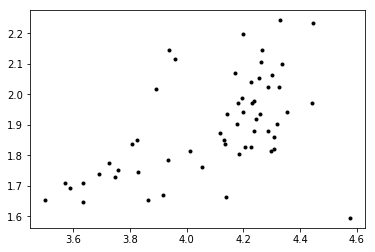

SpearmanrResult(correlation=0.5657655953164923, pvalue=4.514520851039976e-06)


In [8]:
plt.plot(df['qfunc'], df['525_mean'], '.k')
plt.show()
print(scipy.stats.spearmanr(df['qfunc'], df['525_mean'], nan_policy='omit'))

Distribution of ordered variants on all of the flow seq data

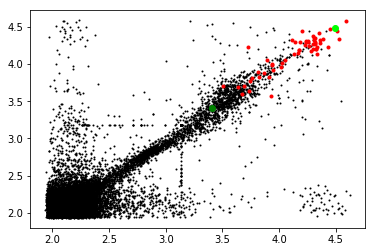

In [9]:
man_flow_id = list(df['id'])

mask = flowseq_df['id'].apply(lambda x: x in man_flow_id)

plt.plot(flowseq_df['qfunc_rep1'], flowseq_df['qfunc_rep2'], '.k', markersize=2)
plt.plot(flowseq_df['qfunc_rep1'][mask], flowseq_df['qfunc_rep2'][mask], '.r') 

plt.plot(flowseq_df[flowseq_df['id'] == 'avGFP']['qfunc_rep1'], 
         flowseq_df[flowseq_df['id'] == 'avGFP']['qfunc_rep2'], 'o', color=[0, 0.5, 0])
plt.plot(flowseq_df[flowseq_df['id'] == 'sfGFP']['qfunc_rep1'], 
         flowseq_df[flowseq_df['id'] == 'sfGFP']['qfunc_rep2'], 'o', color=[0, 1, 0])


plt.show()

## Let's add a column for 'sequence class' to make understanding the relative success of different methods easier.

In [10]:
q = df['id'].apply(lambda s: pd.Series(A008_common.split_seq_id_into_features(s)))
df = df.merge(q, left_index=True, right_index=True)

In [11]:
for i,r in df.iterrows():
    if isinstance(r['id'], str) and not r['id'][:4] == 'GFP_':
        if 'N11' in r['id'] or 'N1' in r['id']:
            df['model'].iloc[i] = 'ASR'
        elif 'consensus_seq' in r['id']:
            df['model'].iloc[i] = 'ConSeq'
    
    if not isinstance(r['id'], str):
        df['model'].iloc[i] = 'Control'
        df['id'].iloc[i] = r['well'] ## FOR NOW ASSIGN ID as well
            
display(df.head())
display(df.tail())

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,id,well,qfunc,525_mean,525_std,man_flow_seq,seq,model,ntrain,rep,rep_hash,seq_traj_idx,special_case
0,GFP_SimAnneal-ET_Random_Init_1-0024-02-1d0c486...,A01,4.575208,1.594774,0.060302,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGCLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGCLTLKF...,ET_Random_Init_1,24.0,2.0,1d0c4863,seq_idx_250_906,
1,GFP_SimAnneal-ET_Global_Init_1-0024-01-3a0e3d4...,A02,4.257005,1.933970,0.015075,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATIGKLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATIGKLTLKF...,ET_Global_Init_1,24.0,1.0,3a0e3d4,seq_idx_372_512,
2,GFP_SimAnneal-ET_Global_Init_1-0024-01-3a0e3d4...,A03,4.225343,1.828442,0.054355,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATHGKLTIKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATHGKLTIKF...,ET_Global_Init_1,24.0,1.0,3a0e3d4,seq_idx_570_153,
3,GFP_SimAnneal-ET_Global_Init_1-0024-03-3764e94...,A04,4.227766,2.039497,0.033710,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,ET_Global_Init_1,24.0,3.0,3764e943,seq_idx_250_3061,
4,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,A05,4.205527,1.828442,0.015075,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLSLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLSLKF...,ET_Global_Init_1,24.0,4.0,4502d3,seq_idx_365_845,


,id,well,qfunc,525_mean,525_std,man_flow_seq,seq,model,ntrain,rep,rep_hash,seq_traj_idx,special_case
75,GFP_SimAnneal-ET_Global_Init_2-0096-02-1f121a7...,H06,3.590448,1.692764,0.045226,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLNLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLNLKF...,ET_Global_Init_2,96.0,2.0,1f121a71,seq_idx_2147_1705,
76,GFP_SimAnneal-ET_Global_Init_1-0096-02-341cf5c...,H07,3.957856,2.114874,0.075377,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATFGKLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATFGKLTLKF...,ET_Global_Init_1,96.0,2.0,341cf5c,seq_idx_2854_226,
77,N1_4_-6.833884__N11_1_-0.180372,H08,NaN,1.504322,0.099956,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,NaN,ASR,NaN,NaN,NaN,NaN,
78,top_consensus_seq,H09,NaN,1.542010,0.015075,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,NaN,ConSeq,NaN,NaN,NaN,NaN,
79,H10,H10,NaN,1.760603,0.099956,NaN,NaN,Control,NaN,NaN,NaN,NaN,


In [12]:
df['model'].value_counts()

ET_Global_Init_1    37
ET_Global_Init_2    16
Control              9
ASR                  9
ConSeq               5
ET_Random_Init_1     4
Name: model, dtype: int64

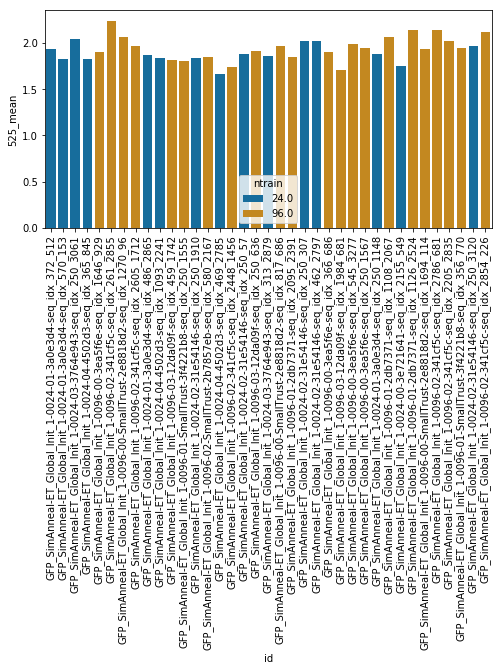

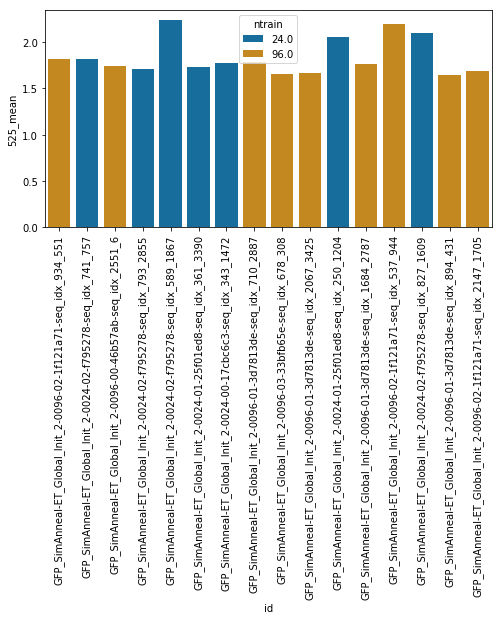

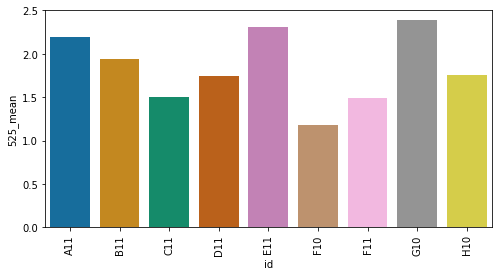

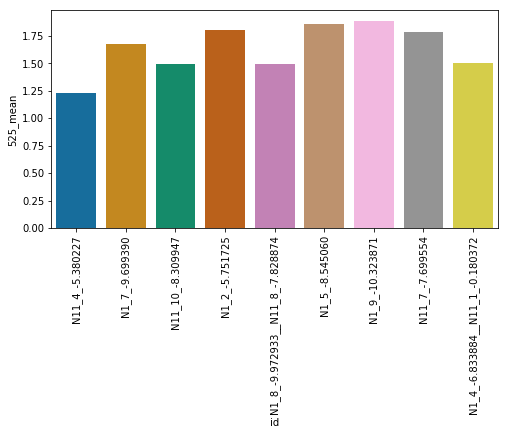

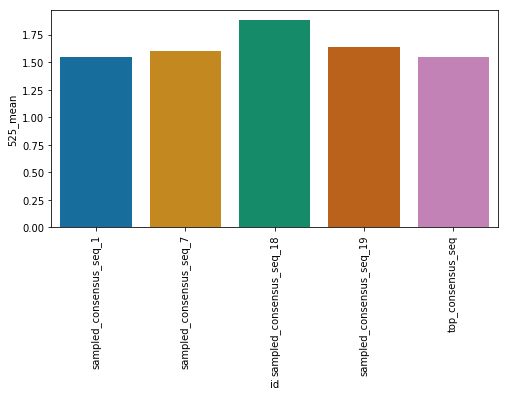

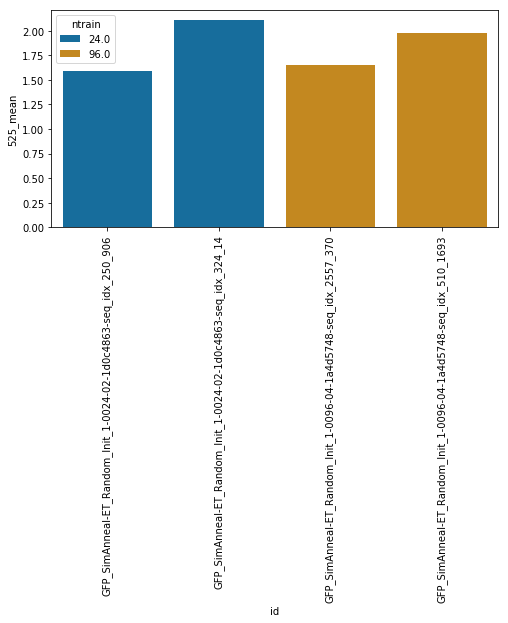

In [13]:
model_cats = list(df['model'].value_counts().index)

for mcat in model_cats:
    mask = df['model'] == mcat
    df_sub = df[mask]
    
    plt.figure(figsize=(8,4))
    
    if 'ET_' in mcat:
        sns.barplot(x='id', y='525_mean', data=df_sub, hue='ntrain', dodge=False, palette='colorblind')
    else:
        sns.barplot(x='id', y='525_mean', data=df_sub, palette='colorblind')
        
    plt.xticks(rotation=90)
    plt.show()

In [14]:
plot_style_utils.set_pub_plot_context()

In [15]:
SFGFP_QFUNC = df['525_mean'][df['well'] == A009_common.SFGFP_WELL].iloc[0]
AVGFP_QFUNC = df['525_mean'][df['well'] == A009_common.AVGFP_WELL].iloc[0]

# Note that the replicate (on the replicate plate) for A009_common.SFGFP_WELL failed. 
# So std deviation, as per the code, is currently reading =0.
# However, we did put sfGFP in another well G10., let's use it's std dev.
SFGFP_QFUNC_STD = df['525_std'][df['well'] == 'G10'].iloc[0]
AVGFP_QFUNC_STD = df['525_std'][df['well'] == A009_common.AVGFP_WELL].iloc[0]


print(SFGFP_QFUNC)
print(AVGFP_QFUNC)

2.3033165829145728
1.489246231155779


ConSeq


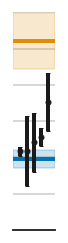

0


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


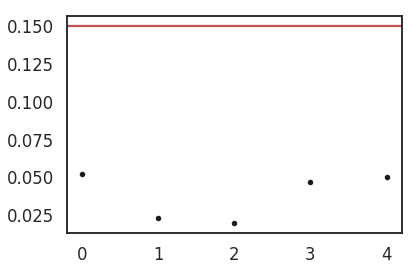

ASR


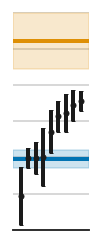

0


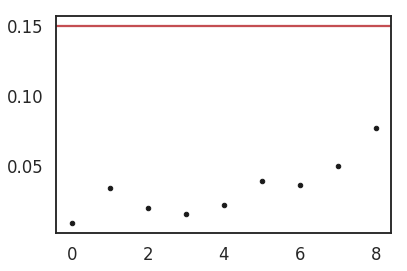

ET_Random_Init_1


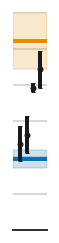

1


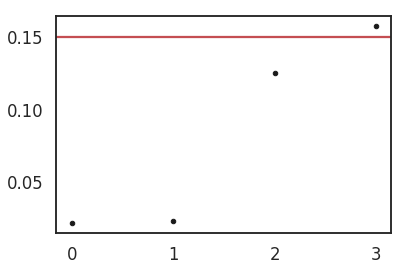

ET_Global_Init_1-2


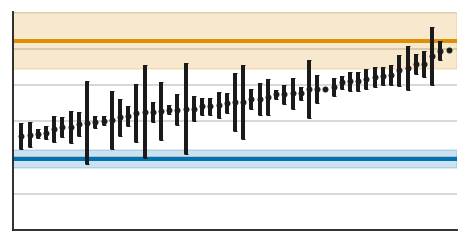

9


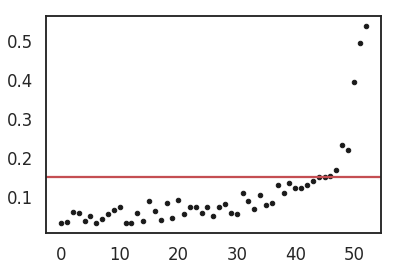

In [16]:
masks = [
    df['model'] == 'ConSeq',
    df['model'] == 'ASR',
    df['model'] == 'ET_Random_Init_1',
    np.logical_or(df['model'] == 'ET_Global_Init_1', df['model'] == 'ET_Global_Init_2')
]

mask_names = ['ConSeq', 'ASR', 'ET_Random_Init_1', 'ET_Global_Init_1-2']
    
for i, mask in enumerate(masks):
    print(mask_names[i])

    df_sub = df[mask]

    fig = plt.figure(figsize=(df_sub.shape[0]*0.15, 4))
    ax = plt.gca()

    plot_style_utils.prettify_ax(ax)

    sidx = np.argsort(df_sub['525_mean'])
    df_sub = df_sub.iloc[sidx]

#     ax.bar(np.arange(df_sub.shape[0]), df_sub['525_mean'], 
#             color=np.array(plot_style_utils.GRAY), linewidth=0.0, edgecolor='k', width=0.8)
    
    ax.errorbar(np.arange(df_sub.shape[0]), df_sub['525_mean'], yerr=2*df_sub['525_std'],
                fmt='ok', markersize=5, capsize=2, linewidth=4)
    
    ax.axhline(AVGFP_QFUNC, color=plot_style_utils.CAT_PALETTE[0], linewidth=4, zorder=1)
    ax.axhline(SFGFP_QFUNC, color=plot_style_utils.CAT_PALETTE[1], linewidth=4, zorder=1)
    
    ax.axhspan(AVGFP_QFUNC - 2*AVGFP_QFUNC_STD, AVGFP_QFUNC + 2*AVGFP_QFUNC_STD, alpha=0.2, 
               color=plot_style_utils.CAT_PALETTE[0])
    ax.axhspan(SFGFP_QFUNC - 2*SFGFP_QFUNC_STD, SFGFP_QFUNC + 2*SFGFP_QFUNC_STD, alpha=0.2, 
               color=plot_style_utils.CAT_PALETTE[1])

    
    
    ax.grid(True)
    ax.set_xlim([-1, np.sum(mask)])
    ax.set_ylim([1.0, 2.5])
    ax.set_xticklabels([])
    ax.set_xticks([])
    
    ax.set_yticklabels([])
    
    if mask_names[i] != 'ET_Global_Init_1-2':
        for j,spine in enumerate(ax.spines.values()):
            if j == 3 or j == 1 or j == 0:
                spine.set_visible(False)

    plt.show()
    plot_style_utils.save_for_pub(fig=fig, path='figures/manual_flow_errorbarplot_' + mask_names[i])
    
    ### P-value calculations ###
    res = scipy.stats.ttest_ind_from_stats(
    np.array([SFGFP_QFUNC]*df_sub.shape[0]), np.array([SFGFP_QFUNC_STD]*df_sub.shape[0]), 2, 
    np.array(df_sub['525_mean']), np.array(df_sub['525_std']), 2, equal_var=False)

    plt.figure()
    plt.plot(res.pvalue, '.k')
    plt.axhline(0.15, color='r')
    print(np.sum(res.pvalue > 0.15))
    plt.show()
    ###
